In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

import os
import gzip

import numpy as np
import tensorflow as tf

import rnndatasets.sequentialmnist as sm

In [73]:
data, labels = sm.get_data('train', 10000)
print(len(data))

10000


In [74]:
def autoencoder_forward(input_var, shape, nonlinearity, tied=True, scope=None):
    """build an autoencoder. `shape` should be a list of
    layer sizes. If tied is True, then we will go through shape twice,
    once forward and once backwards to build the net. Assumes first entry
    of `shape` is the size of the inputs
    Returns a list of outputs for each layer, outputs[-1] is the 
    output of the whole net.
    """
    def affine(name, input_, input_size, layer_size,
               transpose_W=False):
        if not transpose_W:  # normal feedforward
            weights = tf.get_variable(name+'_W', [input_size, layer_size])
            bias = tf.get_variable(name+'_b', [layer_size],
                                  initializer=tf.zeros_initializer)
        else:  # do the weights backwards to make sure we get the same var
            weights = tf.get_variable(name+'_W', [layer_size, input_size])
            # and give the bias a different name
            # somehow it seems that this is not correct to have a fresh
            # bias each time
            bias = tf.Variable(tf.zeros([layer_size]), name=name+'_other_b')
            weights = tf.transpose(weights)
        return tf.nn.bias_add(tf.matmul(input_, weights), bias)
    
    with tf.variable_scope(scope or 'autoencoder') as scope:
        # we have to at least go forward once
        in_size = shape[0]
        layer_input = input_var
        net_outs = []
        for i, layer_size in enumerate(shape[1:]):
            print('{}: ({}, {})'.format(i, layer_size, in_size))
            layer_input = nonlinearity(affine(
                'layer-{}'.format(i),
                layer_input,
                in_size,
                layer_size))
            net_outs.append(layer_input)
            in_size = layer_size
        if tied:
            # do it all again
            scope.reuse_variables()
            for i, layer_size in reversed(list(enumerate(shape[:-1]))):
                print('{}: ({}, {})'.format(i, layer_size, in_size))
                layer_input = nonlinearity(affine(
                    'layer-{}'.format(i),  # important these match up
                    layer_input,
                    in_size,
                    layer_size,
                    True))
                in_size = layer_size
                net_outs.append(layer_input)
        return net_outs

In [86]:
def get_loss_op(net_out, target):
    """Gets MSE between two guys"""
    return tf.reduce_mean(tf.square(net_out - target))

def get_train_op(loss_op):
    """Gets an op to minimise everything in the 
    set of trainable variables"""
    opt = tf.train.GradientDescentOptimizer(0.5)  # how am I getting away with this
    return opt.minimize(loss_op)

In [76]:
def batch_iter(data, batch_size):
    num_batches = data.shape[0] // batch_size
    
    for i in range(num_batches):
        yield data[i*batch_size:(i+1)*batch_size, ...]

In [77]:
tf.reset_default_graph()  # key

# let's do some actual stuff
BATCH_SIZE = 64
SHAPE = [28*28, 256]

inputs = tf.placeholder(tf.float32, name='inputs', shape=[BATCH_SIZE, data.shape[1]])
autoenc_outs = autoencoder_forward(
    inputs, SHAPE, tf.nn.relu, tied=True)
loss_op = get_loss_op(autoenc_outs[-1], inputs)
train_op = get_train_op(loss_op)

0: (256, 784)
0: (784, 256)


In [78]:
# get ready to go
sess = tf.InteractiveSession()
print('...initialising...')
sess.run(tf.initialize_all_variables())
print('done')

...initialising...
done


In [87]:
# actually train
NUM_EPOCHS = 100
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    np.random.shuffle(data)
    num_steps = 0
    for i, batch in enumerate(batch_iter(data, BATCH_SIZE)):
        batch_loss, _ = sess.run([loss_op, train_op],
                                 {inputs: batch.reshape((BATCH_SIZE, -1))})
        total_loss += batch_loss
        num_steps += 1
        if i % 10 == 0:
            print('\r{:.5f}'.format(batch_loss), end='')
    if (epoch+1) % 10 == 0:
        print('                               '
              '\rEpoch {}: loss {}'.format(epoch+1, total_loss/num_steps))

Epoch 10: loss 0.2112610107048964
Epoch 20: loss 0.2112408374937681
Epoch 30: loss 0.2112110752898913
Epoch 40: loss 0.21118105604098394
Epoch 50: loss 0.21116984740663797
Epoch 60: loss 0.21113633354886985
Epoch 70: loss 0.21111661625596193
Epoch 80: loss 0.211099715760121
Epoch 90: loss 0.21108904452278063
Epoch 100: loss 0.21106372286493963


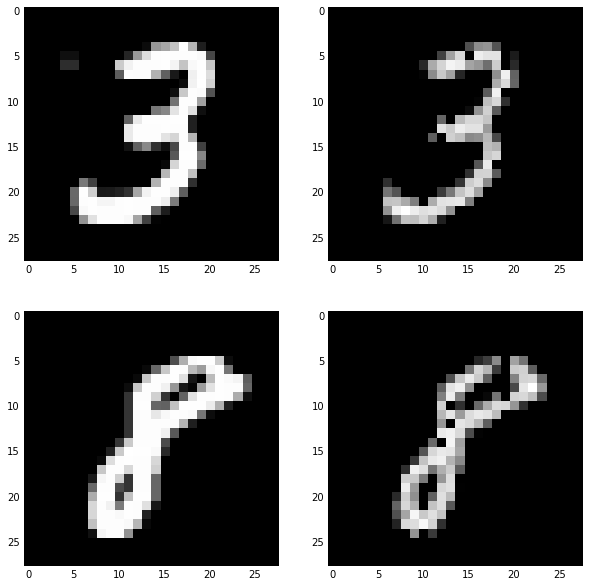

In [91]:
# how about plotting a couple
ims = sess.run(autoenc_outs[-1], {inputs: data[:BATCH_SIZE, ...].reshape((BATCH_SIZE,-1))})

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(data[0,...].reshape((28,28)), cmap='Greys_r', interpolation='nearest')

plt.subplot(222)
plt.imshow(ims[0,...].reshape((28,28)), cmap='Greys_r', interpolation='nearest')

plt.subplot(223)
plt.imshow(data[1,...].reshape((28,28)), cmap='Greys_r', interpolation='nearest')

plt.subplot(224)
plt.imshow(ims[1,...].reshape((28,28)), cmap='Greys_r', interpolation='nearest')